Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [325]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

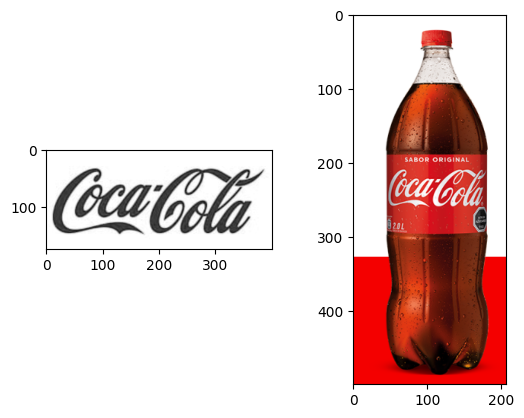

In [326]:
# Cargamos la imagen a procesar
img = cv.imread('images/coca_logo_1.png')

img_rgb= cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)
template = cv.imread('template/pattern.png',0)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_rgb)

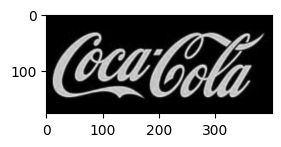

In [327]:
#Definimos la funciona de resize

def resize(template,per=100, n = False):
    #scale_percent = 40 # percent of original size
    scale_percent = per # percent of original size
    width = int(template.shape[1] * scale_percent / 100)
    height = int(template.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    # resize image
    resized = cv.resize(template, dim, interpolation = cv.INTER_AREA)
    if n:
        resized=cv.bitwise_not(resized)
    return resized


template=resize(template,per=100, n = True)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')


Tamaño imagen: (175, 400) pix

Tamaño imagen: (88, 200) pix

Tamaño imagen: (44, 100) pix

Tamaño imagen: (22, 50) pix

Tamaño imagen: (11, 25) pix


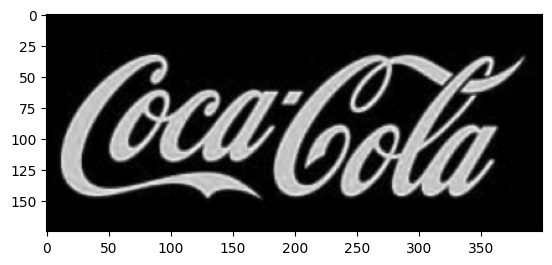

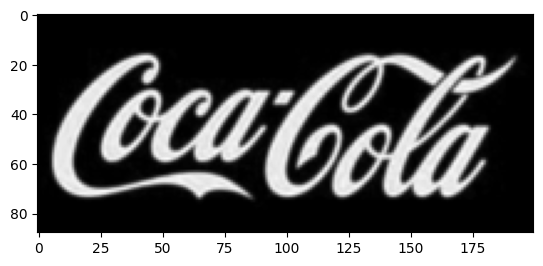

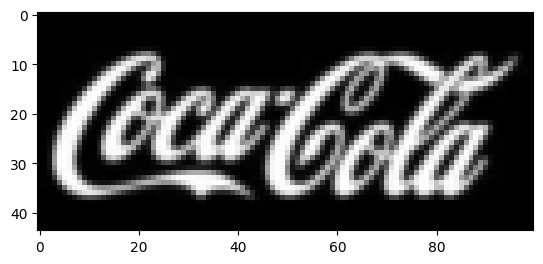

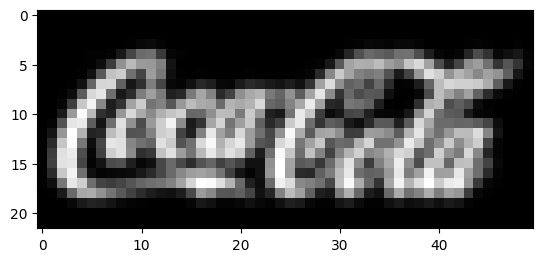

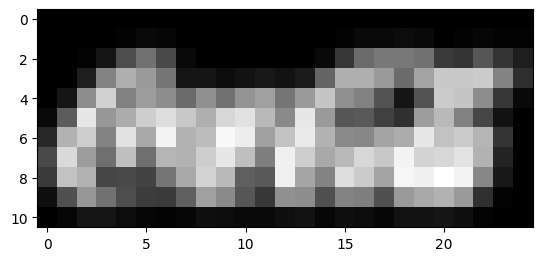

In [328]:
#Applicmos una piramide laplacianas para abajo

img=template

print('\nTamaño imagen: {} pix'.format(img.shape))

#Nivel 1
img_nivel_1 = cv.pyrDown(img)
print('\nTamaño imagen: {} pix'.format(img_nivel_1.shape))

#Nivel 2
img_nivel_2 = cv.pyrDown(img_nivel_1)
print('\nTamaño imagen: {} pix'.format(img_nivel_2.shape))

#Nivel 3
img_nivel_3 = cv.pyrDown(img_nivel_2)
print('\nTamaño imagen: {} pix'.format(img_nivel_3.shape))

#Nivel 4
img_nivel_4 = cv.pyrDown(img_nivel_3)
print('\nTamaño imagen: {} pix'.format(img_nivel_4.shape))

# Muestro los resultados
plt.imshow(img,cmap='gray')
plt.show()
plt.imshow(img_nivel_1,cmap='gray')
plt.show()
plt.imshow(img_nivel_2,cmap='gray')
plt.show()
plt.imshow(img_nivel_3,cmap='gray')
plt.show()
plt.imshow(img_nivel_4,cmap='gray')
plt.show()

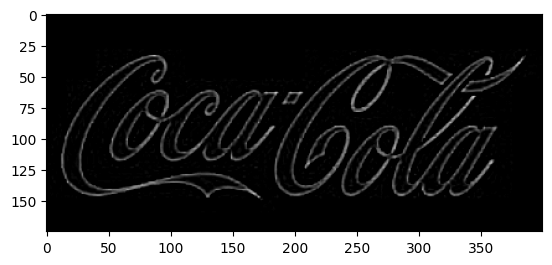

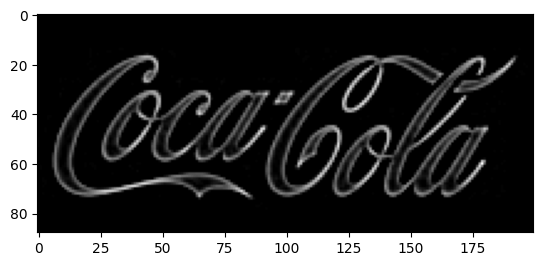

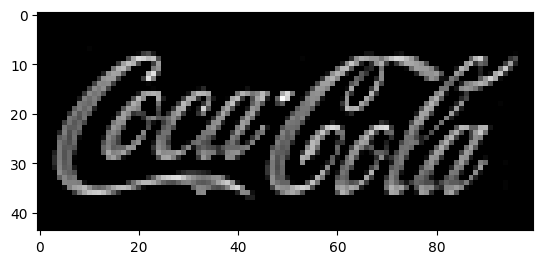

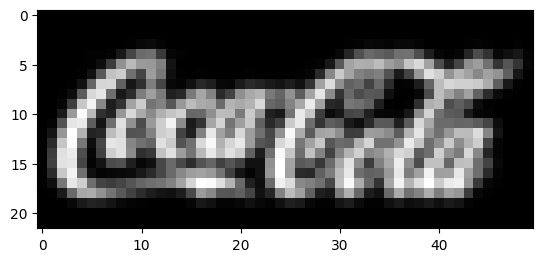

In [329]:
base = template.copy()

# Creamos la pirámide Gaussiana
piramide_gauss = [base]
for i in range(3):
    base = cv.pyrDown(base)
    piramide_gauss.append(base)

# El último nivel de la Gaussiana permanece en el mismo lugar en la Laplaciana
punta_laplaciana = piramide_gauss[-1]
 
# Creamos la pirámide Laplaciana
piramide_laplace = [punta_laplaciana]
for i in range(3,0,-1):
    size = (piramide_gauss[i - 1].shape[1], piramide_gauss[i - 1].shape[0])
    gaussiana_expandida = cv.pyrUp(piramide_gauss[i], dstsize=size)
    laplaciana = cv.subtract(piramide_gauss[i-1], gaussiana_expandida)
    piramide_laplace.append(laplaciana)
    cv.imshow('nivel-{}'.format(i-1),laplaciana)

plt.imshow(piramide_laplace[3],cmap='gray')
plt.show()
plt.imshow(piramide_laplace[2],cmap='gray')
plt.show()
plt.imshow(piramide_laplace[1],cmap='gray')
plt.show()
plt.imshow(piramide_laplace[0],cmap='gray')
plt.show()


In [330]:
#Importo las imagenes

PATH='./images/'


images = [cv.cvtColor(cv.imread(file), cv.COLOR_BGR2RGB) for file in glob.glob(PATH+'*.png')]

In [331]:
# Una vez obtenida la imagen resultado se debe post procesar
# para encontrar los máximos o mínimos de intensidad.
# np.where(), cv.minMaxLoc()
# A tener en cuenta:
# • Utilizar alguna métrica para filtrar solapamiento entre
# detecciones muy cercanas (IoU, NMS, etc…)
# • Hacer un análisis exploratorio y elegir la métrica de
# apropiada.
# • Pre-procesar el template y/o las imágenes para reducir la
# información a correlacionar (canny, pirámides, etc…)
# • La correlación puede dar un falso positivo si se aplica a
# áreas de mucha intensidad ej: zonas blancas.
# • La suma de diferencias puede llevar a resultados erróneos
# si la imagen tiene zonas de baja intensidad.

(500, 207, 3)
(88, 200)
80


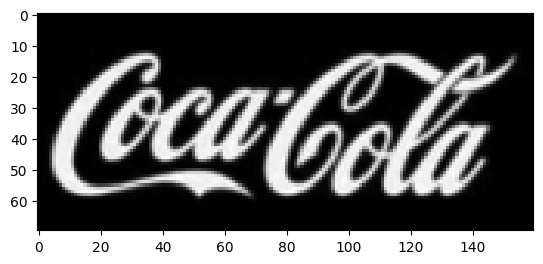

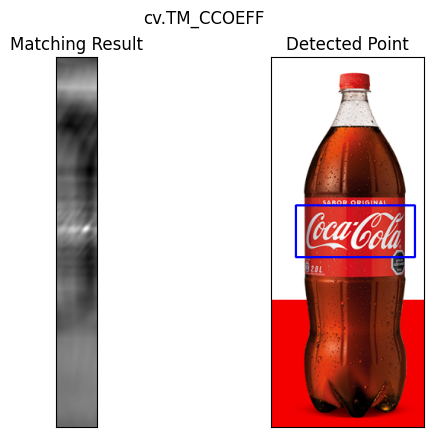

In [342]:
#template=piramide_laplace[2]
meth = 'cv.TM_CCOEFF'
img=images[1]
template_=img_nivel_1
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = img.copy()
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
method = eval(meth)
print(img_salida.shape)
print(template_.shape)

for i in [20]:
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    template_=resize(template_,per=100-i,n=False)
    w, h = template_.shape[::-1]
    res = cv.matchTemplate(img_gray, template_, method)
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)

    #threshold = 0.90
    #loc = np.where( res >= threshold)
    # empty=True
    # for pt in zip(*loc[::-1]):
    #     empty=False
    #     cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    print(100-i)
    plt.figure()
    plt.imshow(template_,cmap='gray')
    plt.show()

    cv.rectangle(img_salida,top_left, bottom_right, (0,0,255), 2)
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()


(493, 715, 3)
(175, 400)
80


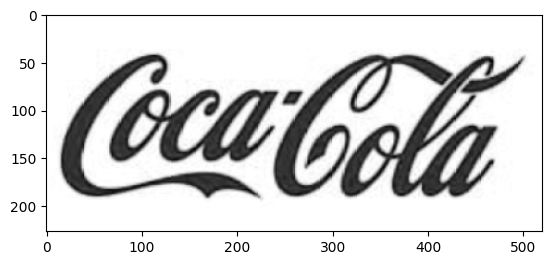

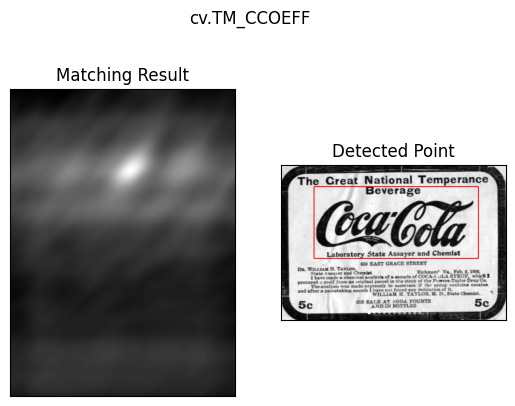

In [333]:
#template=piramide_laplace[2]
meth = 'cv.TM_CCOEFF'
img=images[2]
template_=template
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = img.copy()
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
method = eval(meth)
print(img_salida.shape)
print(template_.shape)

for i in [20]:
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    template_=resize(template_,per=150-i,n=True)
    w, h = template_.shape[::-1]
    try:
        res = cv.matchTemplate(img_gray, template_, method)
    except:
        print("Size exception")
        continue

    
    
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)

    #threshold = 0.90
    #loc = np.where( res >= threshold)
    # empty=True
    # for pt in zip(*loc[::-1]):
    #     empty=False
    #     cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    print(100-i)
    plt.figure()
    plt.imshow(template_,cmap='gray')
    plt.show()

    cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()


(450, 687, 3)
(175, 400)
80


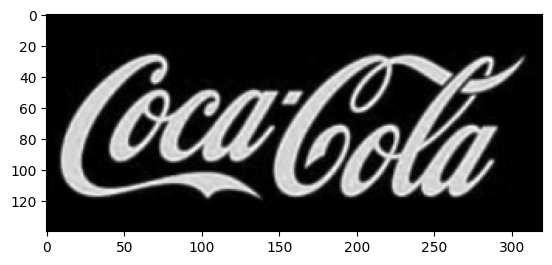

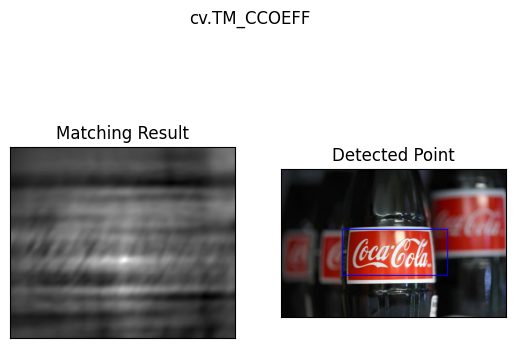

In [341]:
#template=piramide_laplace[2]
meth = 'cv.TM_CCOEFF'
img=images[3]
template_=template
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = img.copy()
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
method = eval(meth)
print(img_salida.shape)
print(template_.shape)

for i in [20]:
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    template_=resize(template_,per=100-i,n=False)
    w, h = template_.shape[::-1]
    try:
        res = cv.matchTemplate(img_gray, template_, method)
    except:
        print("Size exception")
        continue
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)

    #threshold = 0.90
    #loc = np.where( res >= threshold)
    # empty=True
    # for pt in zip(*loc[::-1]):
    #     empty=False
    #     cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    print(100-i)
    plt.figure()
    plt.imshow(template_,cmap='gray')
    plt.show()

    cv.rectangle(img_salida,top_left, bottom_right, (0,0,255), 2)
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()


(363, 233, 3)
(175, 400)
57


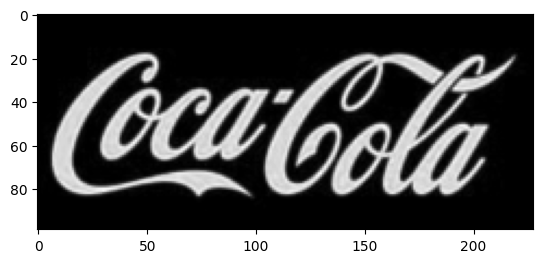

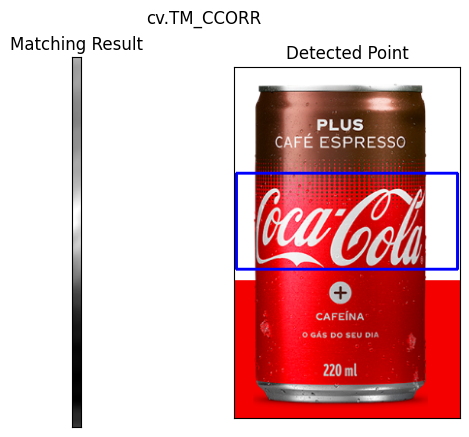

In [340]:
#template=piramide_laplace[2]
meth = 'cv.TM_CCORR'
img=images[4]
template_=template
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = img.copy()
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
method = eval(meth)
print(img_salida.shape)
print(template_.shape)

for i in [43]:
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    template_=resize(template_,per=100-i,n=False)
    w, h = template_.shape[::-1]
    try:
        res = cv.matchTemplate(img_gray, template_, method)
    except:
        print("Size exception")
        continue
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)

    #threshold = 0.90
    #loc = np.where( res >= threshold)
    # empty=True
    # for pt in zip(*loc[::-1]):
    #     empty=False
    #     cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    print(100-i)
    plt.figure()
    plt.imshow(template_,cmap='gray')
    plt.show()

    cv.rectangle(img_salida,top_left, bottom_right, (0,0,255), 2)
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()


(429, 715, 3)
(175, 400)
40


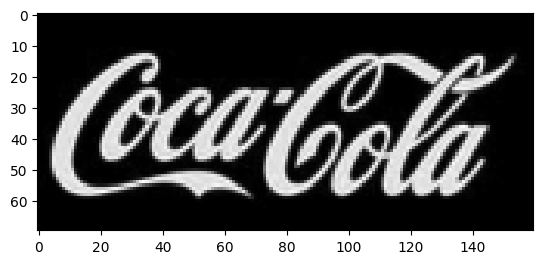

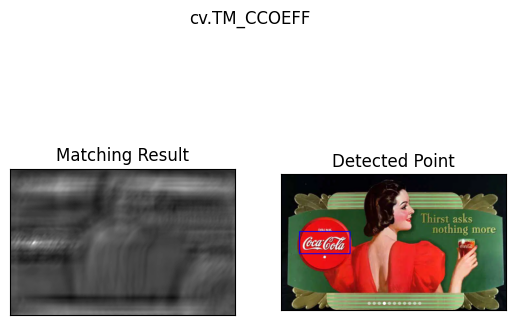

In [339]:
#template=piramide_laplace[2]
meth = 'cv.TM_CCOEFF'
img=images[5]
template_=template
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = img.copy()
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
method = eval(meth)
print(img_salida.shape)
print(template_.shape)

for i in [60]:
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    template_=resize(template_,per=100-i,n=False)
    w, h = template_.shape[::-1]
    try:
        res = cv.matchTemplate(img_gray, template_, method)
    except:
        print("Size exception")
        continue
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)

    #threshold = 0.90
    #loc = np.where( res >= threshold)
    # empty=True
    # for pt in zip(*loc[::-1]):
    #     empty=False
    #     cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    print(100-i)
    plt.figure()
    plt.imshow(template_,cmap='gray')
    plt.show()

    cv.rectangle(img_salida,top_left, bottom_right, (0,0,255), 2)
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()


(598, 799, 3)
(175, 400)
20
(564, 720)


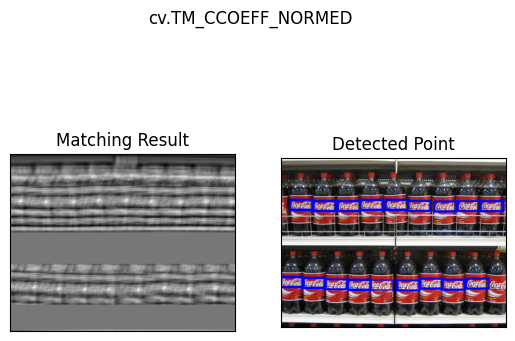

In [337]:
#template=piramide_laplace[2]
meth = 'cv.TM_CCOEFF_NORMED'
img=images[0]
template_=template
# Hago una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
img_salida = img.copy()
img_gray=cv.cvtColor(img_salida, cv.COLOR_BGR2GRAY)
method = eval(meth)
print(img_salida.shape)
print(template_.shape)

for i in [80]:
    # Aplicamos la coincidencia de patrones
    #--------------------------------------
    template_=resize(template_,per=100-i,n=False)
    w, h = template_.shape[::-1]


    try:
        res = cv.matchTemplate(img_gray, template_, method)
    except:
        print("Size exception")
        continue
    # Encontramos los valores máximos y mínimos
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    # bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)

    #threshold = 0.90
    #loc = np.where( res >= threshold)
    # empty=True
    # for pt in zip(*loc[::-1]):
    #     empty=False
    #     cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    # Graficamos el procesamiento y la salida
    #----------------------------------------
    print(100-i)
    # plt.figure()
    # plt.imshow(template_,cmap='gray')
    # plt.show()


    res[250:350,:]=0
    res[480:560,:]=0
    res = cv.GaussianBlur(res,(3,3),0)
    print(res.shape)
    threshold = 0.35 #Sin filtro
    #threshold = 0.246 #    res = cv.GaussianBlur(res,(25,25),0)
    #threshold = 0.15 #    res = cv.GaussianBlur(res,(25,25),0)


    loc = np.where( res >= threshold)

    for pt in zip(*loc[::-1]): 
        cv.rectangle(img_salida, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

    # cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    plt.figure()

    # Resultado de coincidencia
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    # Imagen original con recuadros
    plt.subplot(122),plt.imshow(img_salida)
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])

    plt.suptitle(meth)
    plt.show()
